<a href="https://colab.research.google.com/github/sudhakarmlal/EVA/blob/master/Assignment18/shuffleNet_tfrecords_TensorBoardProfile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
uploaded = files.upload()
!ls

Saving TFRecords_cifar10.py to TFRecords_cifar10.py
sample_data  TFRecords_cifar10.py


In [0]:
!ls

sample_data


In [0]:
!python TFRecords_cifar10.py

Download from https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz and extract.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded cifar-10-python.tar.gz 170498071 bytes.
Generating train.tfrecords


data_dict 4
data_dict 4
data_dict 4
data_dict 4
data_dict 4
Generating validation.tfrecords
data_dict 4
Done!


In [0]:

# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [0]:
print("TensorFlow version: ", tf.__version__)

TensorFlow version:  1.15.0


In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time, math

tf.enable_eager_execution()

filename_train = 'train.tfrecords' 
filename_test = 'validation.tfrecords' 
HEIGHT = 32
WIDTH = 32
DEPTH = 3

Confirm TensorFlow can see the GPU.

In [0]:
device_name = tf.test.gpu_device_name()
if not tf.test.is_gpu_available():
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
def normalize(image):
  """Convert `image` from [0, 255] -> [0, 1] floats."""
  image = tf.cast(image, tf.float32) * (1. / 255)
  return image  

def preprocess(image):
    """Preprocess a single image in [height, width, depth] layout."""
    # Pad 4 pixels on each dimension of feature map, done in mini-batch
    image = tf.image.resize_with_crop_or_pad(image, 40, 40)
    image = tf.image.random_crop(image, [HEIGHT, WIDTH, DEPTH])
    image = tf.image.random_flip_left_right(image)
    return image
def replace_slice(input_: tf.Tensor, replacement, begin) -> tf.Tensor:
    inp_shape = tf.shape(input_)
    size = tf.shape(replacement)
    padding = tf.stack([begin, inp_shape - (begin + size)], axis=1)
    replacement_pad = tf.pad(replacement, padding)
    mask = tf.pad(tf.ones_like(replacement, dtype=tf.bool), padding)
    return tf.where(mask, replacement_pad, input_)
def cutout(x: tf.Tensor, h: int=12, w: int=12, c: int = 3) -> tf.Tensor:
    shape = tf.shape(x)
    x0 = tf.random.uniform([], 0, shape[0] + 1 - h, dtype=tf.int32)
    y0 = tf.random.uniform([], 0, shape[1] + 1 - w, dtype=tf.int32)
    
    x = replace_slice(x, tf.random.uniform([h, w, c], dtype = tf.float32), [x0, y0, 0])
#     x = replace_slice(x, tf.zeros([h, w, c], dtype = tf.float32), [x0, y0, 0])
    return x  

In [0]:
def parser(serialized_example):
    """Parses a single tf.Example into image and label tensors."""
    # Dimensions of the images in the CIFAR-10 dataset.
    # See http://www.cs.toronto.edu/~kriz/cifar.html for a description of the
    # input format.
    features = tf.io.parse_single_example(
        serialized_example,
        features={
            'image': tf.io.FixedLenFeature([], tf.string),
            'label': tf.io.FixedLenFeature([], tf.int64),
        })
    image = tf.io.decode_raw(features['image'], tf.uint8)
    image.set_shape([DEPTH * HEIGHT * WIDTH])
    image = normalize(image)

    # Reshape from [depth * height * width] to [depth, height, width].
    image = tf.cast(
        tf.transpose(tf.reshape(image, [DEPTH, HEIGHT, WIDTH]), [1, 2, 0]),
        tf.float32)
    label = tf.cast(features['label'], tf.int32)
    label = tf.one_hot(label, 10)

    # Custom preprocessing.
    image = preprocess(image)
    image = cutout(image)

    return image, label  
  
def parser_test(serialized_example):
    """Parses a single tf.Example into image and label tensors."""
    # Dimensions of the images in the CIFAR-10 dataset.
    # See http://www.cs.toronto.edu/~kriz/cifar.html for a description of the
    # input format.
    features = tf.io.parse_single_example(
        serialized_example,
        features={
            'image': tf.io.FixedLenFeature([], tf.string),
            'label': tf.io.FixedLenFeature([], tf.int64),
        })
    image = tf.io.decode_raw(features['image'], tf.uint8)
    image.set_shape([DEPTH * HEIGHT * WIDTH])
    image = normalize(image)

    # Reshape from [depth * height * width] to [depth, height, width].
    image = tf.cast(
        tf.transpose(tf.reshape(image, [DEPTH, HEIGHT, WIDTH]), [1, 2, 0]),
        tf.float32)
    label = tf.cast(features['label'], tf.int32)
    label = tf.one_hot(label, 10)

    return image, label    

In [0]:
# Hyperparameters
num_classes = 10
dropout_rate = 0.1
batch_size = 128
num_epochs = 100

In [0]:
# -----------TRAIN TFRecords
# dataset_train = tf.data.TFRecordDataset(filename_train).repeat(1)
# # dataset_test = dataset_train.apply(tf.contrib.data.shuffle_and_repeat(1,40000))
# # dataset_test = dataset_train.apply(tf.contrib.data.map_and_batch(parser,batch_size))
# dataset_train = dataset_train.map(parser, num_parallel_calls=batch_size)
# dataset_train = dataset_train.shuffle(buffer_size=40000) 

# # Batch it up.
# dataset_train = dataset_train.batch(batch_size)
# # iterator = dataset_train.make_one_shot_iterator()
# # image_batch, label_batch = iterator.get_next()

# -------------TEST TFRecords
dataset_test = tf.data.TFRecordDataset(filename_test).repeat(1)
# dataset_test = dataset_test.apply(tf.contrib.data.shuffle_and_repeat(1,10000))
# dataset_test = dataset_test.apply(tf.contrib.data.map_and_batch(parser,batch_size))

dataset_test = dataset_test.map(parser_test, num_parallel_calls=batch_size)
dataset_test = dataset_test.shuffle(buffer_size=10000) 

# Batch it up.
dataset_test = dataset_test.batch(batch_size)
# iterator = dataset_train.make_one_shot_iterator()
# image_batch, label_batch = iterator.get_next()

In [0]:
import tensorflow as tf

def _stage(tensor, nb_groups, in_channels, out_channels, repeat):
    x = _shufflenet_unit(tensor, nb_groups, in_channels, out_channels, 2)

    for _ in range(repeat):
        x = _shufflenet_unit(x, nb_groups, out_channels, out_channels, 1)

    return x


def _pw_group(tensor, nb_groups, in_channels, out_channels):
    """Pointwise grouped convolution."""
    nb_chan_per_grp = in_channels // nb_groups

    pw_convs = []
    for grp in range(nb_groups):
        x = tf.keras.layers.Lambda(lambda x: x[:, :, :, nb_chan_per_grp * grp: nb_chan_per_grp * (grp + 1)])(tensor)
        grp_out_chan = int(out_channels / nb_groups + 0.5)

        pw_convs.append(
            tf.keras.layers.Conv2D(grp_out_chan,
                   kernel_size=(1, 1),
                   padding='same',
                   use_bias=False,
                   strides=1)(x)
        )

    return tf.keras.layers.Concatenate(axis=-1)(pw_convs)


def _shuffle(x, nb_groups):
    def shuffle_layer(x):
        _, w, h, n = tf.keras.backend.int_shape(x)
        nb_chan_per_grp = n // nb_groups

        x = tf.reshape(x, (-1, w, h, nb_chan_per_grp, nb_groups))
        x = tf.keras.backend.permute_dimensions(x, (0, 1, 2, 4, 3)) # Transpose only grps and chs
        x = tf.reshape(x, (-1, w, h, n))

        return x

    return tf.keras.layers.Lambda(shuffle_layer)(x)


def _shufflenet_unit(tensor, nb_groups, in_channels, out_channels, strides, shuffle=True, bottleneck=8):
    bottleneck_channels = out_channels // bottleneck

    x = _pw_group(tensor, nb_groups, in_channels, bottleneck_channels)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    if shuffle:
        x = _shuffle(x, nb_groups)

    x = tf.keras.layers.DepthwiseConv2D(kernel_size=(3, 3),
                        padding='same',
                        use_bias=False,
                        strides=strides)(x)
    x = tf.keras.layers.BatchNormalization()(x)


    x = _pw_group(x, nb_groups, bottleneck_channels,
                  out_channels if strides < 2 else out_channels - in_channels)
    x = tf.keras.layers.BatchNormalization()(x)

    if strides < 2:
        x = tf.keras.layers.Add()([tensor, x])
    else:
        avg = tf.keras.layers.AveragePooling2D(pool_size=(3, 3),
                               strides=2,
                               padding='same')(tensor)

        x = tf.keras.layers.Concatenate(axis=-1)([avg, x])

    x = tf.keras.layers.Activation('relu')(x)

    return x


def _info(nb_groups):
    return {
        1: [24, 144, 288, 576],
        2: [24, 200, 400, 800],
        3: [24, 480],
        4: [24, 272, 544, 1088],
        8: [24, 384, 768, 1536]
    }[nb_groups], [None, 3]


def ShuffleNet(input_shape, nb_classes, include_top=True, weights=None, nb_groups=3):
    x_in = tf.keras.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(24,
               kernel_size=(3, 3),
               strides=1,
               use_bias=False,
               padding='same')(x_in)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    channels_list, repeat_list = _info(nb_groups)
    for i, (out_channels, repeat) in enumerate(zip(channels_list[1:], repeat_list[1:]), start=1):
        x = _stage(x, nb_groups, channels_list[i-1], out_channels, repeat)

    if include_top:
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(nb_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=x_in, outputs=x)

    if weights is not None:
        model.load_weights(weights, by_name=True)

    return model

In [0]:
model = ShuffleNet((32,32,3),10)
model.summary()
# print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_75 (Conv2D)              (None, 32, 32, 24)   648         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_39 (BatchNo (None, 32, 32, 24)   96          conv2d_75[0][0]                  
__________________________________________________________________________________________________
activation_27 (Activation)      (None, 32, 32, 24)   0           batch_normalization_39[0][0]     
____________________________________________________________________________________________

#### ShuffleNet training and evaluation.

Trained for 100 epochs and achieved 80% accuracy on validaton dataset.

In [0]:
from datetime import datetime

log_dir="logs/profile/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch = 3)

In [0]:
import time
sgd = tf.keras.optimizers.SGD(lr=0.005, decay=4e-5, momentum=0.9, nesterov=True)

# tf.keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
                optimizer=sgd,
                metrics=['accuracy'])
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
start_time = time.time()
for zz in range(1,2):#num_epochs+1):
  dataset_train = tf.data.TFRecordDataset(filename_train,num_parallel_reads=16).repeat(3)
  dataset_train = dataset_train.apply(tf.data.experimental.shuffle_and_repeat(50000,1))
  dataset_train = dataset_train.apply(tf.data.experimental.map_and_batch(parser,batch_size, num_parallel_calls=batch_size))
  # It will prefetch the data in (s-1) step
  dataset_train = dataset_train.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
#   dataset_train = dataset_train.map(parser, num_parallel_calls=batch_size)
#   dataset_train = dataset_train.shuffle(buffer_size=50000) 
#   dataset_train = dataset_train.batch(batch_size)
  # determine Loss function and Optimizer
#   print("TrainEpochs number{}/{}".format(zz,num_epochs))
  
  model.fit_generator(dataset_train,steps_per_epoch=int(50000/batch_size),epochs=3,verbose=1, callbacks = [tensorboard_callback],
                     validation_data=dataset_test,validation_steps=int(10000/batch_size),validation_freq=2)#,validation_data=dataset_test)

#   print("Test Epochs number{}/{}".format(zz,num_epochs))
  model.evaluate_generator(dataset_test,steps=int(10000/batch_size),verbose=1)
  print("  ")
  print("------------------------",time.time()-start_time)

Epoch 1/3
390/390 [==============================] - 69s 176ms/step - loss: 1.8158 - acc: 0.3211
Epoch 2/3
390/390 [==============================] - 72s 186ms/step - loss: 1.5583 - acc: 0.4247 - val_loss: 2.2646 - val_acc: 0.3230
Epoch 3/3
78/78 [==============================] - 5s 67ms/step - loss: 1.3636 - acc: 0.5210
  
------------------------ 213.9889702796936


In [0]:
!ls -l logs/profile/

total 16
drwxr-xr-x 3 root root 4096 Nov 16 13:39 20191116-123253
drwxr-xr-x 3 root root 4096 Nov 16 14:09 20191116-134010
drwxr-xr-x 3 root root 4096 Nov 16 14:09 20191116-140938
drwxr-xr-x 3 root root 4096 Nov 16 14:48 20191116-144756


In [0]:
%tensorboard --logdir logs/profile/

Reusing TensorBoard on port 6008 (pid 528), started 1:39:44 ago. (Use '!kill 528' to kill it.)

In [0]:
from google.colab import files
files.download('logs/')

FileNotFoundError: ignored

In [0]:
!tar -zcvf logs.tar.gz logs/profile/

logs/profile/
logs/profile/20191116-144756/
logs/profile/20191116-144756/events.out.tfevents.1573915685.ee93146e1a1e.profile-empty
logs/profile/20191116-144756/events.out.tfevents.1573915684.ee93146e1a1e.v2
logs/profile/20191116-144756/plugins/
logs/profile/20191116-144756/plugins/profile/
logs/profile/20191116-144756/plugins/profile/2019-11-16_14-48-05/
logs/profile/20191116-144756/plugins/profile/2019-11-16_14-48-05/local.trace
logs/profile/20191116-134010/
logs/profile/20191116-134010/events.out.tfevents.1573911614.ee93146e1a1e.profile-empty
logs/profile/20191116-134010/plugins/
logs/profile/20191116-134010/plugins/profile/
logs/profile/20191116-134010/plugins/profile/2019-11-16_13-40-14/
logs/profile/20191116-134010/plugins/profile/2019-11-16_13-40-14/local.trace
logs/profile/20191116-134010/events.out.tfevents.1573911613.ee93146e1a1e.v2
logs/profile/20191116-134010/events.out.tfevents.1573913372.ee93146e1a1e.v2
logs/profile/20191116-140938/
logs/profile/20191116-140938/plugins/
lo

In [0]:
!tensorboard --logdir=logs/ --port=6006

W1116 16:07:02.933924 139775707567872 plugin_event_accumulator.py:294] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
E1116 16:07:03.034522 139775841019776 program.py:228] TensorBoard could not bind to port 6006, it was already in use
ERROR: TensorBoard could not bind to port 6006, it was already in use


In [0]:
!nvidia-smi

Sun Oct 20 18:46:24 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    62W / 149W |   4330MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

#### VISUALIZING CUTOUT

In [0]:
batch_size = 5

dataset_train = tf.data.TFRecordDataset(filename_train).repeat(1)
# dataset_test = dataset_train.apply(tf.contrib.data.shuffle_and_repeat(1,40000))
# dataset_test = dataset_train.apply(tf.contrib.data.map_and_batch(parser,batch_size))
dataset_train = dataset_train.map(parser, num_parallel_calls=batch_size)
dataset_train = dataset_train.shuffle(buffer_size=40000) 
dataset_train = dataset_train.batch(batch_size)

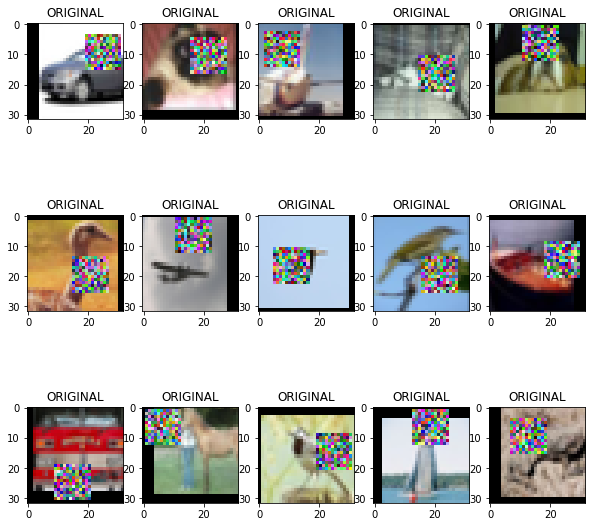

In [0]:
% matplotlib inline
z=0
fig, ax = plt.subplots(3,5, figsize=(10,10))
for j,i in enumerate(dataset_train):
#     print("test",i[0].shape,i[1].shape,j)
    for l,k in enumerate(i[0]):
#         print(k.shape)
#         print(z,l)
        ax[z,l].imshow(k)
        ax[z,l].set_title("ORIGINAL")
    z += 1
    if z == 3:  
      break

#### MISS-CLASSIFIED IMAGES

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()

Using TensorFlow backend.


170500096/170498071 [==============================] - 2s 0us/step


In [0]:
import numpy as np
import matplotlib.pyplot as plt

j,t = 0, 0
X_test_wrong = []
X_test_wrong_raw = []
for i in range(len(test_features)):
  img_data = test_features[i].astype('float32')
  img_data /= 255
  img_data = np.expand_dims(img_data, axis=0)
#   img_data = test_features[i].reshape(1, 32, 32,3)
  t += 1
#   print(model.predict(img_data)[0])
#   print(np.argmax(model.predict(img_data)[0]))
#   print(test_labels[i][0])
  if np.argmax(model.predict(img_data)[0]) != test_labels[i][0]:
    X_test_wrong.append((img_data, np.argmax(model.predict(img_data)[0]), test_labels[i][0]))
    X_test_wrong_raw.append((test_features[i], np.argmax(model.predict(img_data)[0]), test_labels[i][0]))
    j += 1
  if j >= 50:
    break
print('totla false preds {} for samples {}'.format(j,t))

totla false preds 50 for samples 259


**We see that 50 out of first 259 samples are mis-classified, which is approximately 80% accuracy**

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

**Showing the 50 mis-classified images, to understand the reason why they are mis-classified.**

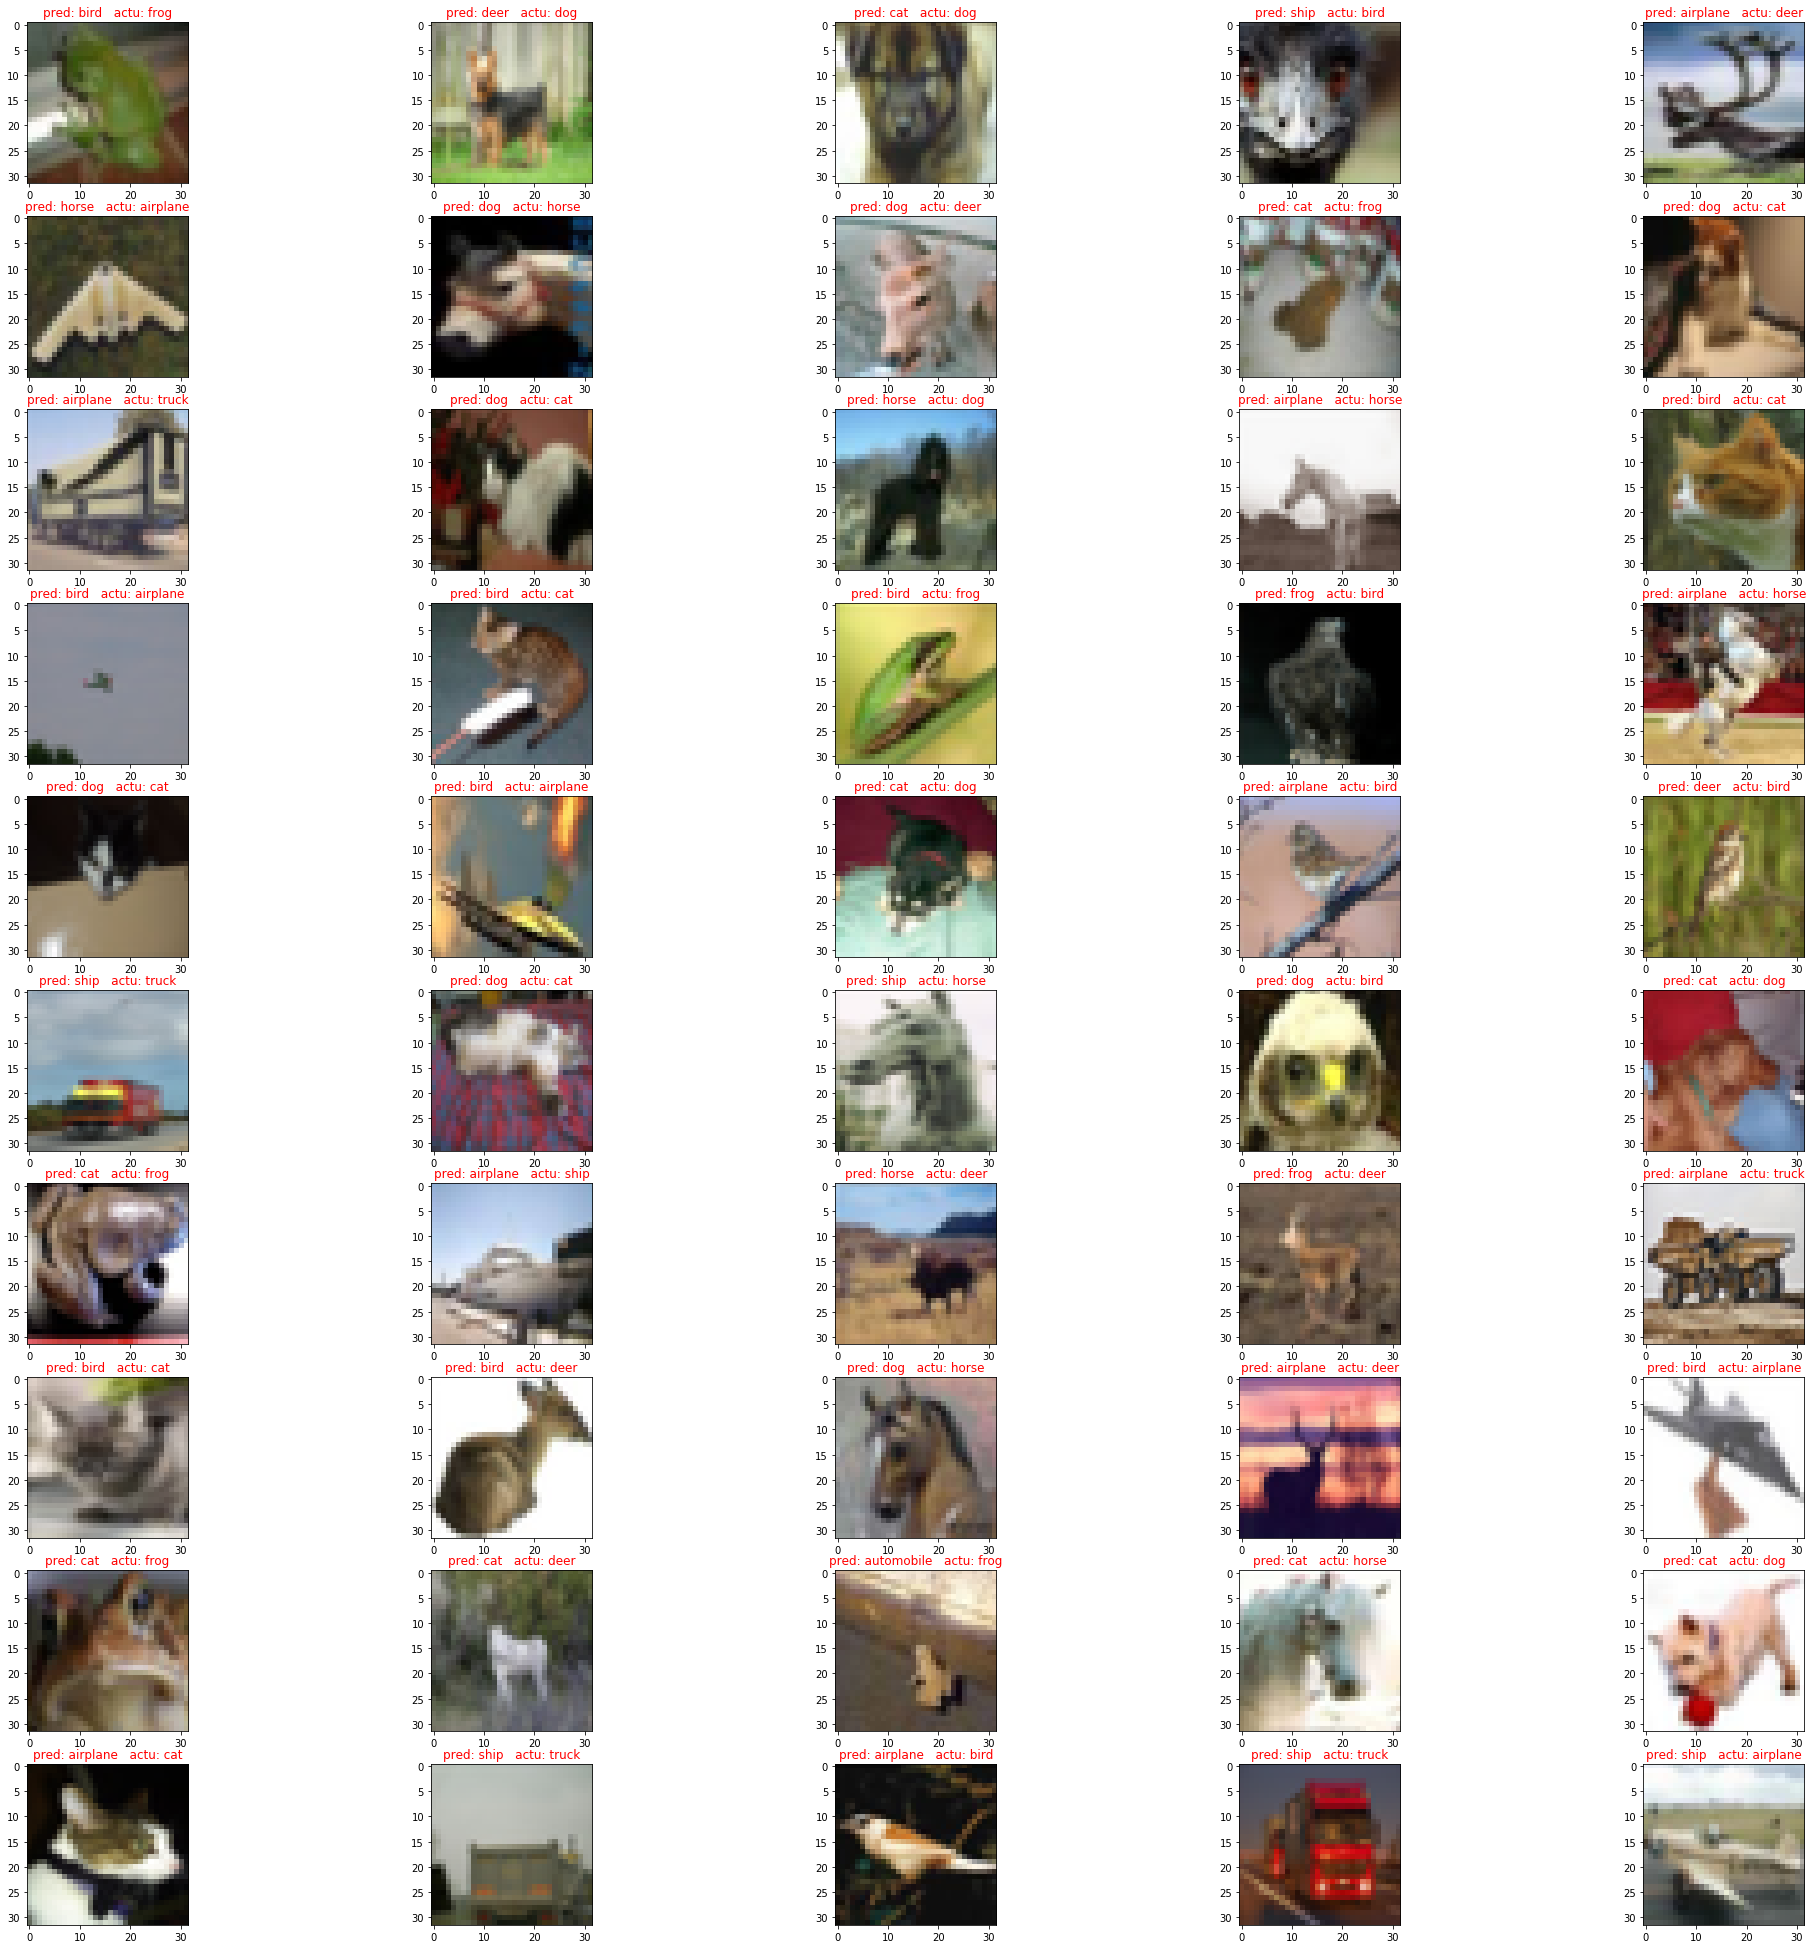

In [0]:
plt.figure(figsize=(35,35))
batch_size = 25
i = 0
for img in X_test_wrong:
  ax = plt.subplot(10,5,i+1)
  ax.set_title("pred: {}   actu: {}".format(class_names[img[1]], class_names[img[2]]), color='r')
  plt.imshow(np.reshape(np.uint8(255 * img[0]), (32,32,-1)), cmap=plt.cm.gray)
  i += 1